In [34]:
import pandas as pd
import numpy as np
import math
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

file_name='RM_MCs.csv'
df=pd.read_csv(file_name,parse_dates=True,index_col='date_of_service_dttm')

print(df.shape[0])
print('number of patients:',len(df.mrn.unique()))
print (df.head())

### strain out val dfs
# df_val=pd.read_csv('UC_recurrent_mrns.csv')
# try:
#     df_val.MRN=df_val.MRN.str.replace('-','')
#     df_val.MRN=df_val.MRN.astype('int64')
# except:
#     print('mrns are already in correct form')
    
# mrns_val=df_val.MRN.unique()
    
# df=df[~df['mrn'].isin(mrns_val)]
# print('number of patients without val cohort:',len(df.mrn.unique()))

## strain out people that start with RM=1 and have super long notes

7397
number of patients: 171
                          mrn  is_RM
date_of_service_dttm                
1996-02-26            2050963      0
2009-01-23            2050963      0
2009-10-01            2050963      0
2010-02-19            2050963      0
2010-03-01            2050963      0


In [35]:
### convert to monthly
# create sub df by mrn

def convert_to_monthly(df):
    ptx_info=df_by_patient(df)
    for index,ptx in enumerate(ptx_info):
        ptx_info[index]=to_monthly(ptx)
    df_rebuilt=rebuild_df(ptx_info)
    return df_rebuilt
    
    
def df_by_patient(df):
    '''returns a list of dataframes divided by mrn'''
    ptx_info=[]
    for index,mrn in enumerate(df.mrn.unique()):
        sub_df=df[df['mrn']==mrn]
        ptx_info.append(sub_df)
    return ptx_info

# ptx_info=df_by_patient(df)
### re index to monthly

def to_monthly(df_input):
    df_working=df_input

    df_d=df_working.resample('D').mean()
    df_d['mrn']=df_d['mrn'].ffill()
    df_d['is_RM']=df_d['is_RM'].ffill()

    df_m=df_d.resample('M').mean()
    df_m.is_RM.value_counts()

    df_m['is_RM']=df_m['is_RM'].apply(lambda a:a>0).astype(int)
    return df_m

def rebuild_df(ptx_info):
    df_rebuilt=''
    for index,ptx in enumerate(ptx_info):
        if index==0:
            df_rebuilt=ptx_info[0]
        else:
            df_rebuilt=df_rebuilt.append(ptx)
    return df_rebuilt

# for index,ptx in enumerate(ptx_info):
#     ptx_info[index]=to_monthly(ptx)
# print (len(ptx_info))
# print (ptx_info[0])

df_monthly=convert_to_monthly(df)
print (df_monthly)

                            mrn  is_RM
date_of_service_dttm                  
1996-02-29            2050963.0      0
1996-03-31            2050963.0      0
1996-04-30            2050963.0      0
1996-05-31            2050963.0      0
1996-06-30            2050963.0      0
...                         ...    ...
2018-11-30            3793494.0      1
2018-12-31            3793494.0      1
2018-07-31            3715744.0      1
2018-08-31            3715744.0      1
2018-09-30            3715744.0      1

[8630 rows x 2 columns]


In [36]:
from datetime import datetime,timedelta

def time_elapsed(start_date,current_date):
    '''get difference between two datetimes'''
    time=current_date-start_date
    return time

def times_elapsed(df):
    '''from a sorted df with a datetime index get a list of how many days it has been since 1st encounter'''
    start_date=df.index[0].to_pydatetime()
    times=[]
    for index,row in df.iterrows():
        current_date=index.to_pydatetime()
        time=time_elapsed(start_date,current_date)
        times.append(time.days)
    return times

ptx_info=df_by_patient(df_monthly)
for index,df in enumerate(ptx_info):
    ptx_info[index]['months_elapsed']=times_elapsed(df)
df=rebuild_df(ptx_info)
df['months_elapsed']=df['months_elapsed']/30
df['months_elapsed']=df['months_elapsed'].round(0).astype(int)
print (df)

### select for timelines that are 6 years or less
good_mrns=[]
ptx_info=df_by_patient(df)
for index,ptx in enumerate(ptx_info):
    if ptx.iloc[0]['is_RM'] != 1 and ptx.iloc[-1]['months_elapsed']<=72:
        good_mrns.append(ptx.iloc[0]['mrn'])
df=df[df['mrn'].isin(good_mrns)]
print('number of patients that start without disease and have shortish notes:',len(df.mrn.unique()))

C:\Users\12488\python\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                            mrn  is_RM  months_elapsed
date_of_service_dttm                                  
1996-02-29            2050963.0      0               0
1996-03-31            2050963.0      0               1
1996-04-30            2050963.0      0               2
1996-05-31            2050963.0      0               3
1996-06-30            2050963.0      0               4
...                         ...    ...             ...
2018-11-30            3793494.0      1               4
2018-12-31            3793494.0      1               5
2018-07-31            3715744.0      1               0
2018-08-31            3715744.0      1               1
2018-09-30            3715744.0      1               2

[8630 rows x 3 columns]
number of patients that start without disease and have shortish notes: 117


In [37]:
print (df.columns)
col_names=['mrn','Recurrence Status','months_elapsed']
df.columns=col_names
print (df.columns)

Index(['mrn', 'is_RM', 'months_elapsed'], dtype='object')
Index(['mrn', 'Recurrence Status', 'months_elapsed'], dtype='object')


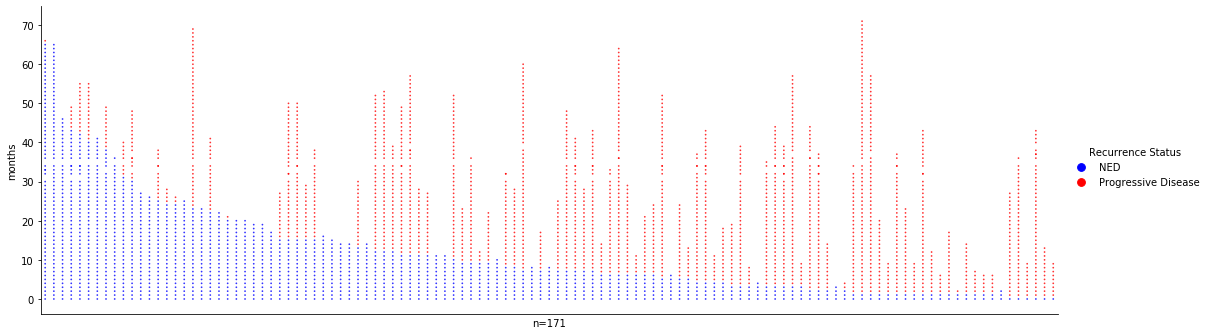

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

d={}
counts=[]
for mrn in df.mrn.unique():
    df_sub=df[df.mrn==mrn]
    df_sub=df_sub.sort_values(by='months_elapsed')
    if df_sub.iloc[0]['Recurrence Status']==1:
        d[mrn]=df_sub.iloc[-1]['months_elapsed'] * -1
    elif df_sub['Recurrence Status'].sum()==0:
        d[mrn]=df_sub.iloc[-1]['months_elapsed']
    else:
        start=df_sub.iloc[0].months_elapsed
        end=df_sub.iloc[-1].months_elapsed
        keep_going=True
        for index,row in df_sub.iterrows():
            if keep_going and row['Recurrence Status']==1:
                keep_going=False
                end=row['months_elapsed']
        d[mrn]=end-start
for index,row in df.iterrows():
    counts.append(d[row['mrn']])
df['rank_order']=counts
df=df.sort_values(by='rank_order',ascending=False)
order=df.mrn.unique()

### map recurrence status to boolean
map_={0:'NED',1:'Progressive Disease'}
df['Recurrence Status']=df['Recurrence Status'].map(map_)

df_working=df
#df_working['mrn']=df_working['mrn'].astype(str)
grid=sns.catplot(x='mrn', y="months_elapsed", hue="Recurrence Status", palette={'NED':'Blue','Progressive Disease':'Red'},jitter=False, 
                 **{'alpha':.8,'s':1.75},data=df_working, height=5, aspect=3,order=order)
#grid.set(ylim=(-100,8000))
grid.set(xlabel='n='+str(len(ptx_info)),ylabel='months')
grid.set(xticks=[])
#grid.fig.suptitle('(n='+str(len(ptx_info))+')')
plt.savefig('recurrence_timeline_monthly.png')
